In [1]:
%matplotlib inline

In [12]:
import pandas as pd
import glob
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

In [14]:
import matplotlib
###Default for jupyter display
matplotlib.rcParams['figure.dpi']= 150

matplotlib.rcParams['xtick.labelsize'] = 8
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['legend.fontsize'] = 10
# matplotlib.rcParams['text.usetex'] = True

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [21]:
lifestyle_df = pd.read_csv('../Data/MVP_data/lifestyle_results_BACPHLIP.tsv', sep='\t', index_col=2)
lifestyle_df = lifestyle_df.drop('Unnamed: 0', axis=1)
print(lifestyle_df.shape)
print(lifestyle_df['host_id'].value_counts())
lifestyle_df.head()

(1333, 3)
562       374
287       163
1280      136
573       100
470        94
657318     81
1639       58
1428       53
1314       44
90371      40
357276     38
28450      34
1590       33
435591     26
36809      22
305        20
717959     17
Name: host_id, dtype: int64


,host_id,phage_lifestyle,lifestyle_probability_difference
phage_id,,,
7759,1314,Virulent,0.750000
18244,1314,Temperate,0.975000
628,1314,Temperate,0.925000
4578,1314,Virulent,0.548421
1738,1314,Temperate,0.925000


In [42]:
taxon_id = 90371
temp_lifestyle_df = lifestyle_df[lifestyle_df['host_id']==int(taxon_id)]

combined_df = pd.read_csv('../Data/MVP_data/host_genomes/{}.tsv'.format(taxon_id), sep='\t', index_col=0)
assert len(list(combined_df['genome_id'].value_counts().keys())) == 1
host_name = combined_df['genome_id'].value_counts().keys()[0]
temp_df = combined_df
t_vals_a = []
t_vals_b = []
p_vals_a = []
p_vals_b = []
lifestyle_vals = []
for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/{}_rep_viruses/*.clean.tsv'.format(taxon_id))[:]:
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
#     if lifestyle_df.loc[int(vir_name)]['lifestyle_probability_difference'] < 0.9:
#         continue
    lifestyle_vals.append(temp_lifestyle_df.loc[int(vir_name)]['phage_lifestyle'])   

    concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
#     fitted = smf.logit('binary_predictor ~ RBS_energy', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ RBS_energy + GC_upstream', data=concat_df).fit(disp=0)
    fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ secondary_structure', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure + GC_cds + iCUB', data=concat_df).fit(disp=0)
#     beta_vals_a.append(fitted.params[1])
#     beta_vals_b.append(fitted.params[2])
    #
    t_vals_a.append(fitted.tvalues[1])
    t_vals_b.append(fitted.tvalues[2])
    #
    p_vals_a.append(fitted.pvalues[1])
    p_vals_b.append(fitted.pvalues[2])

Text(0, 0.5, 'T-value for secondary structure')

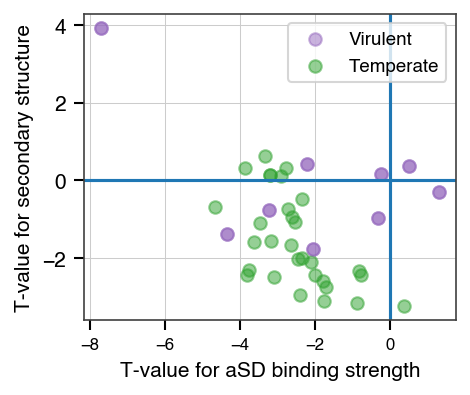

In [43]:
fig, ax = plt.subplots(figsize=(3.2,2.7))

ax.scatter([i for i,j in zip(t_vals_a, lifestyle_vals) if j=='Virulent'],\
           [i for i,j in zip(t_vals_b, lifestyle_vals) if j=='Virulent'],\
           c=colors[4], alpha=0.5, label='Virulent')
ax.scatter([i for i,j in zip(t_vals_a, lifestyle_vals) if j=='Temperate'],\
           [i for i,j in zip(t_vals_b, lifestyle_vals) if j=='Temperate'],\
           c=colors[2], alpha=0.5, label='Temperate')

ax.scatter([i for i,j in zip(t_vals_a, lifestyle_vals) if j=='Virulent'],\
           [i for i,j in zip(t_vals_b, lifestyle_vals) if j=='Virulent'],\
           c=colors[4], alpha=0.5)

ax.axvline(0, c=colors[0])
ax.axhline(0, c=colors[0])
# ax.set_xlim(-15, 15)
# ax.set_ylim(-15, 15)
plt.legend(loc=1, fontsize=9)
ax.set_xlabel('T-value for aSD binding strength')
ax.set_ylabel('T-value for secondary structure')
# plt.savefig(figs_dir + '/Ecoli_{}_tval_scatter.png'.format(col_name), dpi=300, bbox_inches='tight')